In [1]:
import pickle
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.utils import shuffle

import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from scipy.stats import norm

def sort_data_random(df):
    np.random.seed(0)
    df['random'] = np.random.random(size=len(df))
    sorted_df = df.sort_values(by=['fitness', 'random'], ascending=[False, True])
    sorted_df = sorted_df.drop(columns=['random'])
    return sorted_df

def sample_data(sub_dir_name, target, cache_dict, num_fold, root_dir, sample_num, objective_index):
    data_dict = {}
    for sub_dir in sub_dir_name:
        smiles2fitness_dict = {}
        if sub_dir == "original data":
            continue
        all_smiles_list = []
        for i in range(1, num_fold+1):
            smiles_list = []
            fitness_list = []
            dir_name = os.path.join(root_dir, sub_dir+"_"+str(i))
            with open(os.path.join(dir_name, "population_explore.txt"), "r") as f:
                smiles_list += f.read().strip().split(" ")
            with open(os.path.join(dir_name, "fitness_explore.txt"), "r") as f:
                fitness_list += f.read().strip().split(" ")
            with open(os.path.join(dir_name, "population_local_search.txt"), "r") as f:
                smiles_list += f.read().strip().split(" ")
            with open(os.path.join(dir_name, "fitness_local_search.txt"), "r") as f:
                fitness_list += f.read().strip().split(" ")
            fitness_list = [float(x) for x in fitness_list]
            for smiles, fitness in zip(smiles_list, fitness_list):
                smiles2fitness_dict.update({smiles: fitness})
            smiles_fitness_data = list(zip(smiles_list, fitness_list))
            unique_data = set_and_sort(smiles_fitness_data)
            all_smiles_list += list(zip(*unique_data[:sample_num]))[0]
        data = pd.DataFrame(columns=[target])
        all_smiles_list = list(set(all_smiles_list))
        for smiles in all_smiles_list:
            scores = cache_dict.get(smiles)
            if scores:
                if type(scores) in [float, int]:
                    if scores != 10000:
                        score = float(scores)
                    else:
                        score = float("nan")
                elif abs(scores[0]) != 10000:
                    scores = list(scores)
                    score = scores[objective_index]
                else:
                    score = float("nan")
#             else:
#                 score = float("nan")
                data = pd.concat([data, pd.DataFrame([[smiles]+[score]], columns=["smiles"]+[target])], axis=0)
        data["fitness"] = [smiles2fitness_dict.get(smiles) for smiles in data["smiles"]]
        data_dict.update({sub_dir: sort_data_random(data).reset_index(drop=True)})# data.sort_values(by="fitness", ascending=False).reset_index(drop=True)})
    return data_dict

def set_and_sort(data):
    seen_names = set()
    unique_data = []
    for name, score in data:
        if name not in seen_names:
            seen_names.add(name)
            unique_data.append((name, score))
    unique_data.sort(key=lambda x: x[1], reverse=True)
    return unique_data

def create_1dplot(benchmark_dict, sub_dir_name, target, color_dict, num_points=100):
    plt.figure()
    for i, sub_dir in enumerate(sub_dir_name):
        if sub_dir == "original data":
            data = benchmark_dict[sub_dir]
        else:
            data = benchmark_dict[sub_dir][:num_points]
        plt.scatter(data[target], [i/5] * len(data[target]), c=color_dict[sub_dir], s=10, alpha=0.75)
    plt.ylim(-0.5, 1)
    plt.yticks([])
    plt.xlabel(target)
    plt.show()

def is_pass_cutoff(data, objective, cutoff, cache_dict, predict_dict, objective_index):
    reference_founds = []
    predict_founds = []
    for smiles in data["smiles"]:
        reference_score = cache_dict[smiles][objective_index]
        predict_score = predict_dict[smiles][objective_index]
        if objective == "maximize":
            reference_founds.append(int(reference_score > cutoff))
            predict_founds.append(int(predict_score > cutoff))
        elif objective == "minimize":
            reference_founds.append(int(reference_score < cutoff))
            predict_founds.append(int(predict_score < cutoff))
        else:
            raise ValueError("objective can only be either maximize or minimize.")
    return reference_founds, predict_founds

def create_confusion_matrix_plot(data_dict, method_list, target, objective, cutoff, cache_dict, predict_dict, objective_index):
    for method in method_list:
        if method == "original data":
            continue
        reference_founds, predict_founds = is_pass_cutoff(data_dict[method], objective, cutoff, cache_dict, predict_dict, objective_index)
        print(method)
        print(reference_founds)
        print(predict_founds)
        print("precision:", precision_score(reference_founds, predict_founds))
        ConfusionMatrixDisplay.from_predictions(reference_founds, predict_founds, normalize="all")
    return

def compute_precision(data_dict, method_list, target, objective, cutoff, cache_dict, predict_dict, objective_index):
    for method in method_list:
        if method == "original data":
            continue
        reference_founds, predict_founds = is_pass_cutoff(data_dict[method], objective, cutoff, cache_dict, predict_dict, objective_index)
        print(method)
        print("precision:", precision_score(reference_founds, predict_founds))
    return

def compute_hit_rate(benchmark_dict, method_list, cutoff, target, objective, top_list=[10,50,100]):
    for top_num in top_list:
        for method in method_list:
            # sub_data = benchmark_dict[method].dropna()[:top_num]
            if target == "oscillator_strength":
                sub_data = benchmark_dict[method].fillna(0)[:top_num]
            else:
                sub_data = benchmark_dict[method].fillna(max(benchmark_dict[method][:100][target]))[:top_num]
            if objective == "maximize":
                found = len(sub_data[sub_data[target] >= cutoff])
            elif objective == "minimize":
                found = len(sub_data[sub_data[target] <= cutoff])
            print(f"{method}, top-{top_num} hit rate: {found/top_num*100}%")
            
def create_pd_plot(benchmark_dict, sub_dir_name, color_dict, target, objective, cutoff,save_path=None, sample_num=100, oneplot=True, ylabel=True, bins=30, expand_xlim=False):
    target_name_dict = {"1syh score":"1SYH score", "4lde score":"4LDE score", "6y2f score":"6Y2F score",
                    "singlet-triplet value":"Singlet-triplet gap", "oscillator strength":"Oscillator strength", 
                    "abs_diff_vee":"Abs. diff.of VEE",
                    "activation_energy":"Activation energy", "reaction_energy":"Reaction energy",
                    "1syh_score":"1SYH score", "4lde_score":"4LDE score", "6y2f_score":"6Y2F score",
                    "singlet-triplet_value":"Singlet-triplet gap", "oscillator_strength":"Oscillator strength", }
    xlabel_name = target_name_dict.get(target, target)
    max_y = 0
    if oneplot:
        plt.figure()
    # values = [benchmark_dict[sub_dir].dropna()[:sample_num][target] for sub_dir in sub_dir_name]
    if target == "oscillator_strength":
        values = [benchmark_dict[sub_dir].fillna(0)[:sample_num][target] for sub_dir in sub_dir_name] 
    else:
        values = [benchmark_dict[sub_dir].fillna(max(benchmark_dict[sub_dir][:100][target]))[:sample_num][target] for sub_dir in sub_dir_name] 
    for sub_dir in sub_dir_name:
        # Plot the histogram
        color = color_dict[sub_dir]
        bins = np.histogram(np.hstack(values), bins=bins)[1]
        # y, x, _ = plt.hist(benchmark_dict[sub_dir].dropna()[:sample_num][target],bins=bins,density=False,alpha=0.7,color=color,label=sub_dir)
        if target == "oscillator_strength":
            y, x, _ = plt.hist(benchmark_dict[sub_dir].fillna(0)[:sample_num][target],bins=bins,density=False,alpha=0.7,color=color,label=sub_dir)
        else:
            y, x, _ = plt.hist(benchmark_dict[sub_dir].fillna(max(benchmark_dict[sub_dir][:100][target]))[:sample_num][target],bins=bins,density=False,alpha=0.7,color=color,label=sub_dir)
        max_y = max(max(y), max_y)
    # plt.xlabel(target +"\n("+objective+")", fontsize=14)
    plt.xlabel(xlabel_name, fontsize=15)
    plt.plot([cutoff, cutoff], [0, max_y], linestyle='--', color='black', label='cutoff')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    if expand_xlim:
        current_xlim = plt.xlim()
        new_xlim = (current_xlim[0] - (current_xlim[1] - current_xlim[0]) * 0.05,
                    current_xlim[1])
        plt.xlim(new_xlim)
        

    if ylabel:
#         plt.ylabel('Probability Density', fontsize=14)
        plt.ylabel('Count', fontsize=15)
    if save_path:
        plt.savefig(save_path)
    if oneplot:
        plt.show()

def append_prediction(df, predict_dict, target, prediction_index, uncertainty_index):
    predictions = []
    uncertainties = []
    for smiles in df["smiles"]:
        values = predict_dict.get(smiles)
        if values:
            predictions.append(float(values[prediction_index]))
            uncertainties.append(float(values[uncertainty_index]))
        else:
            predictions.append(float("nan"))
            uncertainties.append(float("nan"))

    new_df = df.copy()
    new_df[target+"_pred"] = predictions
    new_df[target+"_pred_unc"] = uncertainties
    return new_df

def create_scatter_plot(benchmark_dict, predict_dict, target, prediction_index, uncertainty_index, cutoff, top_num=50, legend=True, show=True):
    scaler_df = append_prediction(benchmark_dict["janus_scaler"], predict_dict, target, prediction_index, uncertainty_index)[:top_num]
    pio_df = append_prediction(benchmark_dict["janus_uncertainty"], predict_dict, target, prediction_index, uncertainty_index)[:top_num]
    ei_df = append_prediction(benchmark_dict["janus_expected_improvement"], predict_dict, target, prediction_index, uncertainty_index)[:top_num]
    # Create the parity plot with standard deviation as error bars
    if show:
        plt.figure(figsize=(6, 6))
    x1 = plt.errorbar(scaler_df[target], scaler_df[target+"_pred"], yerr=scaler_df[target+"_pred_unc"], fmt='o', color='crimson', label='DOM', capsize=3, alpha=0.5)
    x2 = plt.errorbar(pio_df[target], pio_df[target+"_pred"], yerr=pio_df[target+"_pred_unc"], fmt='o', color='mediumspringgreen', label='PIO', capsize=3, alpha=0.5)
    x3 = plt.errorbar(ei_df[target], ei_df[target+"_pred"], yerr=ei_df[target+"_pred_unc"], fmt='o', color='#6A5ACD', label='EI', capsize=3, alpha=0.5)

    # Plot the 45 degree reference line
    min_val = min(list(scaler_df[target])+list(scaler_df[target+"_pred"])+list(pio_df[target])+list(pio_df[target+"_pred"])+list(ei_df[target]))
    max_val = max(list(scaler_df[target])+list(scaler_df[target+"_pred"])+list(pio_df[target])+list(pio_df[target+"_pred"])+list(ei_df[target]))
    plt.plot([min_val, max_val], [min_val, max_val], 'k-', label=None)
    x4, = plt.plot([cutoff, cutoff], [min_val, max_val], 'k--', label="cutoff")
    if legend:
        plt.legend(handles=[x1,x2,x3,x4], labels=['DOM', 'PIO', 'EI', 'cutoff'], prop={'size': 12})

    # Set axis limits
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)

    # Add labels and title
    plt.xlabel('Reference values', fontsize=20)
    plt.ylabel('Predictions', fontsize=20)
    plt.title(target.replace("_", " "), fontsize=20)
    if show:
        plt.show()

overall_benchmark_dict = {}

## Organic emitter (singlet-triplet value)

janus_scaler, top-10 hit rate: 0.0%
janus_uncertainty, top-10 hit rate: 0.0%
janus_expected_improvement, top-10 hit rate: 0.0%
janus_scaler, top-50 hit rate: 0.0%
janus_uncertainty, top-50 hit rate: 2.0%
janus_expected_improvement, top-50 hit rate: 0.0%
janus_scaler, top-100 hit rate: 0.0%
janus_uncertainty, top-100 hit rate: 1.0%
janus_expected_improvement, top-100 hit rate: 0.0%


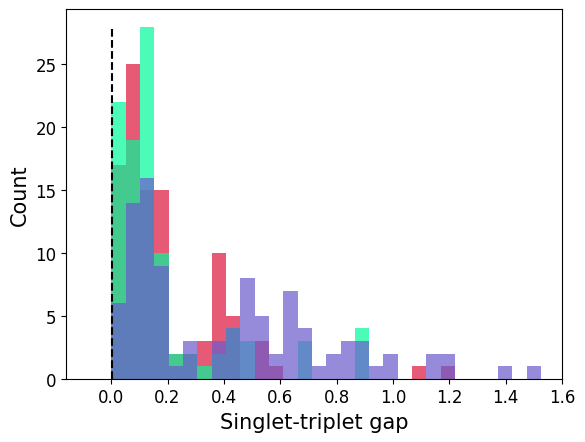

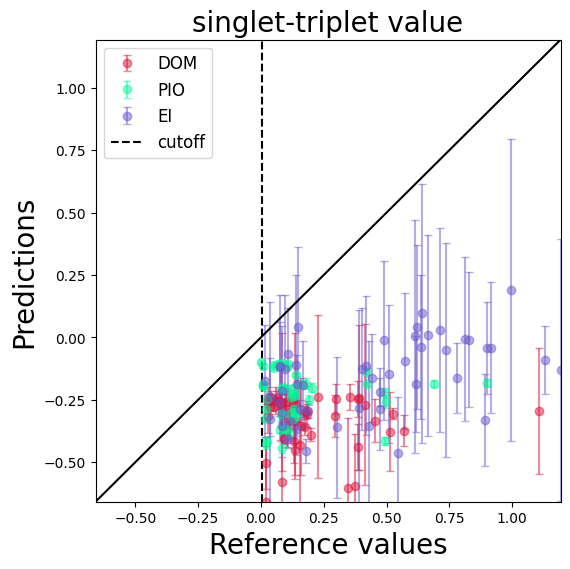

In [3]:
data_set = "organic_emitter"
target = "singlet-triplet_value"
data_path = "../Tartarus/datasets/gdb13.csv"
root_dir = "../RESULTS/{}".format(data_set+"_singlet-triplet_value")
objective_index = 0
objective = "minimize"
cutoff = 0.002495
save_path = "figures/1.svg"
prediction_index = 0
uncertainty_index = 3


cache_dict_path = "../RESULTS/{}/cal_dict.pkl".format(data_set)
predict_dict_path = "../RESULTS/{}/predict_dict.pkl".format(data_set)
with open(cache_dict_path, "rb") as f:
    cache_dict = pickle.load(f)
    
with open(predict_dict_path, "rb") as g:
    predict_dict = pickle.load(g)
    
sub_dir_name = ["janus_scaler", "original data", "janus_uncertainty", "janus_expected_improvement"]

color_dict = {"original data": "black", "janus_scaler":"crimson", "janus_uncertainty":"mediumspringgreen", "janus_expected_improvement":"#6A5ACD"}
num_fold = 15


data = pd.read_csv(data_path)
benchmark_dict = sample_data(sub_dir_name, target, cache_dict, num_fold, root_dir, -1, objective_index)
benchmark_dict.update({"original data": data})
overall_benchmark_dict.update({target: benchmark_dict})

method_list = ["janus_scaler", "janus_uncertainty", "janus_expected_improvement"]
compute_hit_rate(benchmark_dict, method_list, cutoff, target, objective, top_list=[10,50,100])
create_pd_plot(benchmark_dict, ["janus_scaler", "janus_uncertainty", "janus_expected_improvement"], color_dict, target, objective, cutoff, save_path=save_path, expand_xlim=True)
# create_pd_plot(benchmark_dict, ["janus_expected_improvement"], color_dict, target, objective, cutoff, save_path="figures/ei_1.svg", expand_xlim=True)
create_scatter_plot(benchmark_dict, predict_dict, target, prediction_index, uncertainty_index, cutoff)

## Organic emitter (oscillator strength)

janus_scaler, top-10 hit rate: 0.0%
janus_uncertainty, top-10 hit rate: 10.0%
janus_expected_improvement, top-10 hit rate: 10.0%
janus_scaler, top-50 hit rate: 0.0%
janus_uncertainty, top-50 hit rate: 6.0%
janus_expected_improvement, top-50 hit rate: 10.0%
janus_scaler, top-100 hit rate: 3.0%
janus_uncertainty, top-100 hit rate: 13.0%
janus_expected_improvement, top-100 hit rate: 7.000000000000001%


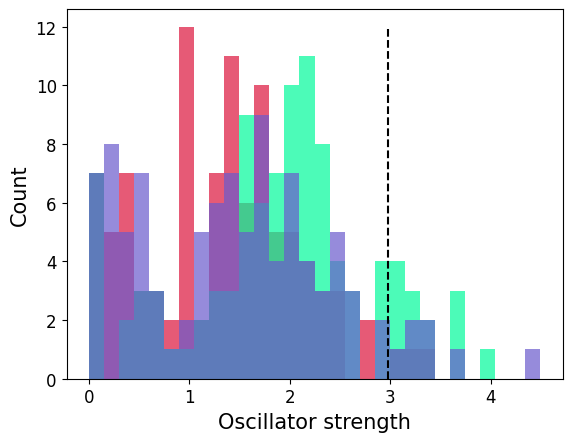

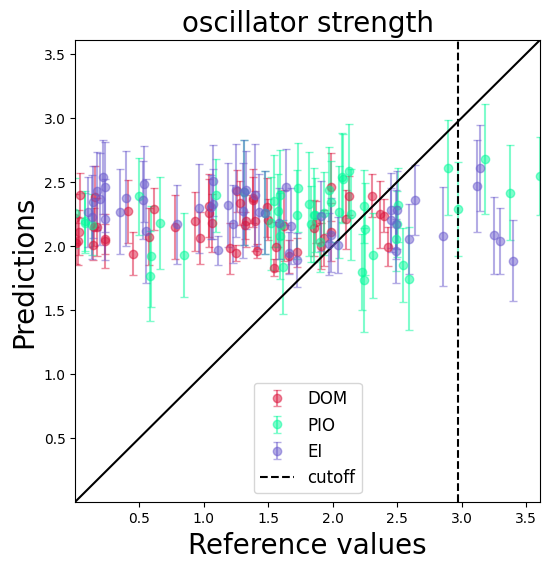

In [4]:
data_set = "organic_emitter"
target = "oscillator_strength"
data_path = "../Tartarus/datasets/gdb13.csv"
root_dir = "../RESULTS/{}".format(data_set+"_oscillator_strength")
objective_index = 1
objective = "maximize"
cutoff = 2.97372
save_path = "figures/2.svg"
predictino_index = 1
uncertainty_index = 4

cache_dict_path = "../RESULTS/{}/cal_dict.pkl".format(data_set)
predict_dict_path = "../RESULTS/{}/predict_dict.pkl".format(data_set)
with open(cache_dict_path, "rb") as f:
    cache_dict = pickle.load(f)
    
with open(predict_dict_path, "rb") as g:
    predict_dict = pickle.load(g)
    
sub_dir_name = ["janus_scaler", "original data", "janus_uncertainty", "janus_expected_improvement"]

color_dict = {"original data": "black", "janus_scaler":"crimson", "janus_uncertainty":"mediumspringgreen", "janus_expected_improvement":"#6A5ACD"}
num_fold = 15


data = pd.read_csv(data_path)
benchmark_dict = sample_data(sub_dir_name, target, cache_dict, num_fold, root_dir, -1, objective_index)
benchmark_dict.update({"original data": data})
overall_benchmark_dict.update({target: benchmark_dict})

method_list = ["janus_scaler", "janus_uncertainty", "janus_expected_improvement",]
compute_hit_rate(benchmark_dict, method_list, cutoff, target, objective, top_list=[10,50,100])
create_pd_plot(benchmark_dict, ["janus_scaler", "janus_uncertainty", "janus_expected_improvement"], color_dict, target, objective, cutoff, save_path=save_path)
# create_pd_plot(benchmark_dict, ["janus_expected_improvement"], color_dict, target, objective, cutoff, save_path="figures/ei_2.svg")
create_scatter_plot(benchmark_dict, predict_dict, target, prediction_index, uncertainty_index, cutoff)

## Docking 1syh score (single objective)

janus_scaler, top-10 hit rate: 0.0%
janus_uncertainty, top-10 hit rate: 0.0%
janus_expected_improvement, top-10 hit rate: 0.0%
janus_scaler, top-50 hit rate: 0.0%
janus_uncertainty, top-50 hit rate: 0.0%
janus_expected_improvement, top-50 hit rate: 0.0%
janus_scaler, top-100 hit rate: 0.0%
janus_uncertainty, top-100 hit rate: 0.0%
janus_expected_improvement, top-100 hit rate: 0.0%


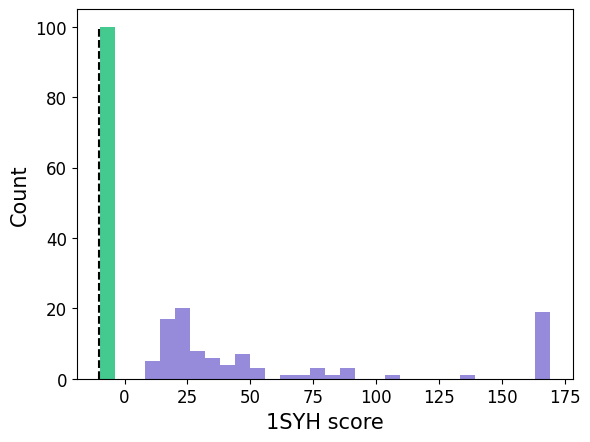

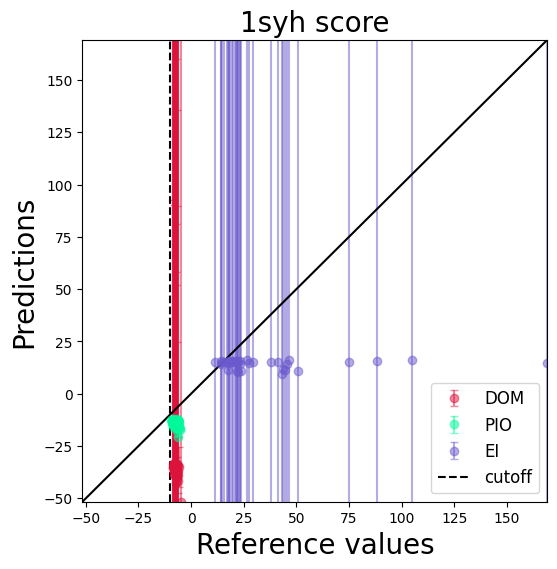

In [6]:
data_set = "docking"
target = "1syh_score"
data_path = "../Tartarus/datasets/docking.csv"
root_dir = "../RESULTS/{}".format(data_set+"_1syh_score")
objective_index = 0
cutoff = -9.99
objective = "minimize"
save_path = "figures/3.svg"
prediction_index = 0
uncertainty_index = 3

cache_dict_path = "../RESULTS/{}/cal_dict.pkl".format(data_set)
predict_dict_path = "../RESULTS/{}/predict_dict.pkl".format(data_set)
with open(cache_dict_path, "rb") as f:
    cache_dict = pickle.load(f)
with open(predict_dict_path, "rb") as g:
    predict_dict = pickle.load(g)
    
sub_dir_name = ["janus_scaler", "original data", "janus_uncertainty", "janus_expected_improvement"]
color_dict = {"original data": "black", "janus_scaler":"crimson", "janus_uncertainty":"mediumspringgreen", "janus_expected_improvement":"#6A5ACD"}

num_fold = 15


data = pd.read_csv(data_path)
benchmark_dict = sample_data(sub_dir_name, target, cache_dict, num_fold, root_dir, -1, objective_index)
benchmark_dict.update({"original data": data})


method_list = ["janus_scaler", "janus_uncertainty", "janus_expected_improvement"]
compute_hit_rate(benchmark_dict, method_list, cutoff, target, objective, top_list=[10,50,100])
overall_benchmark_dict.update({target: benchmark_dict})

create_pd_plot(benchmark_dict, ["janus_scaler", "janus_uncertainty", "janus_expected_improvement"], color_dict, target, objective, cutoff, save_path=save_path)
# create_pd_plot(benchmark_dict, ["janus_expected_improvement"], color_dict, target, objective, cutoff, save_path="figures/ei_3.svg")
create_scatter_plot(benchmark_dict, predict_dict, target, prediction_index, uncertainty_index, cutoff)

## Docking 4lde score (single objective)

janus_scaler, top-10 hit rate: 40.0%
janus_uncertainty, top-10 hit rate: 80.0%
janus_expected_improvement, top-10 hit rate: 0.0%
janus_scaler, top-50 hit rate: 48.0%
janus_uncertainty, top-50 hit rate: 92.0%
janus_expected_improvement, top-50 hit rate: 2.0%
janus_scaler, top-100 hit rate: 49.0%
janus_uncertainty, top-100 hit rate: 92.0%
janus_expected_improvement, top-100 hit rate: 3.0%


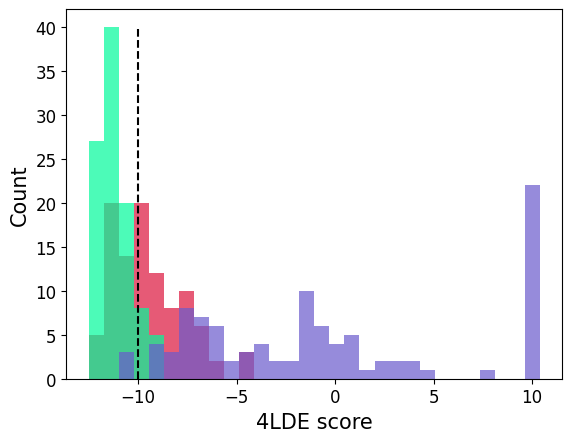

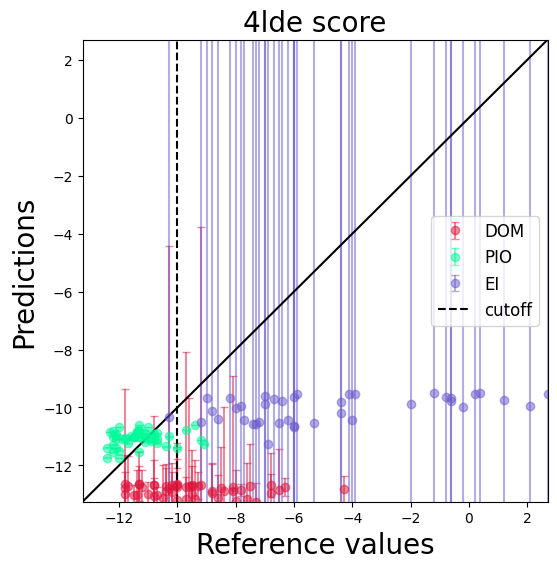

In [8]:
data_set = "docking"
target = "4lde_score"
data_path = "../Tartarus/datasets/docking.csv"
root_dir = "../RESULTS/{}".format(data_set+"_4lde_score")
objective_index = 1
save_path = "figures/4.svg"
prediction_index = 1
uncertainty_index = 4

cache_dict_path = "../RESULTS/{}/cal_dict.pkl".format(data_set)
predict_dict_path = "../RESULTS/{}/predict_dict.pkl".format(data_set)
with open(cache_dict_path, "rb") as f:
    cache_dict = pickle.load(f)
with open(predict_dict_path, "rb") as g:
    predict_dict = pickle.load(g)
    
sub_dir_name = ["janus_scaler", "original data", "janus_uncertainty", "janus_expected_improvement"]

cutoff = -10.00
objective = "minimize"

color_dict = {"original data": "black", "janus_scaler":"crimson", "janus_uncertainty":"mediumspringgreen", "janus_expected_improvement":"#6A5ACD"}
num_fold = 15


data = pd.read_csv(data_path)
benchmark_dict = sample_data(sub_dir_name, target, cache_dict, num_fold, root_dir, -1, objective_index)
benchmark_dict.update({"original data": data})
overall_benchmark_dict.update({target: benchmark_dict})

method_list = ["janus_scaler", "janus_uncertainty", "janus_expected_improvement"]
compute_hit_rate(benchmark_dict, method_list, cutoff, target, objective, top_list=[10,50,100])
# create_1dplot(benchmark_dict, sub_dir_name, target, color_dict)
create_pd_plot(benchmark_dict, ["janus_scaler", "janus_uncertainty", "janus_expected_improvement"], color_dict, target, objective, cutoff, save_path=save_path)
# create_pd_plot(benchmark_dict, ["janus_expected_improvement"], color_dict, target, objective, cutoff, save_path="figures/ei_4.svg")
create_scatter_plot(benchmark_dict, predict_dict, target, prediction_index, uncertainty_index, cutoff)

## Docking 6y2f score (single objective)

janus_scaler, top-10 hit rate: 40.0%
janus_uncertainty, top-10 hit rate: 80.0%
janus_expected_improvement, top-10 hit rate: 0.0%
janus_scaler, top-50 hit rate: 54.0%
janus_uncertainty, top-50 hit rate: 56.00000000000001%
janus_expected_improvement, top-50 hit rate: 0.0%
janus_scaler, top-100 hit rate: 50.0%
janus_uncertainty, top-100 hit rate: 49.0%
janus_expected_improvement, top-100 hit rate: 0.0%


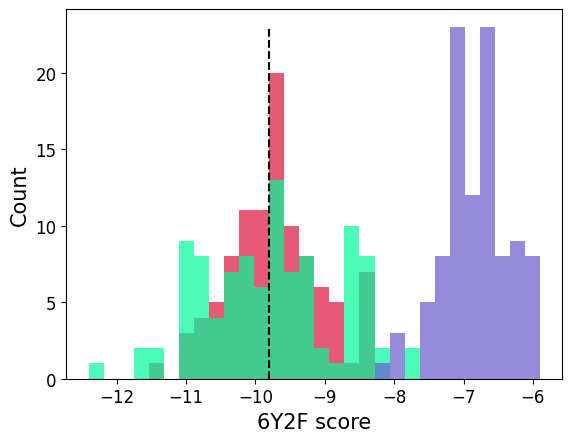

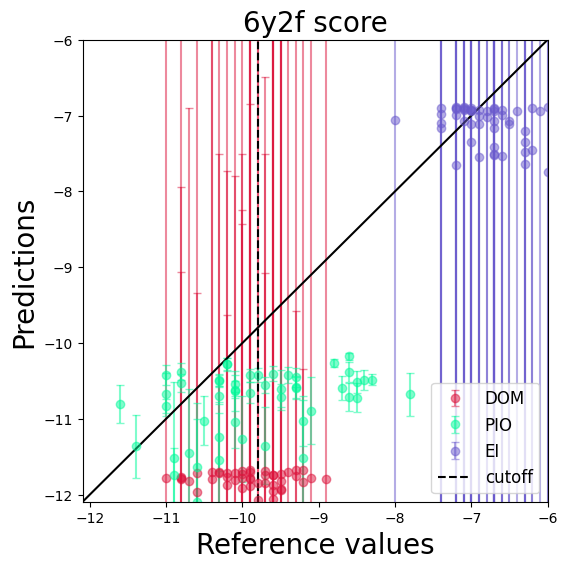

In [9]:
data_set = "docking"
target = "6y2f_score"
data_path = "../Tartarus/datasets/docking.csv"
root_dir = "../RESULTS/{}".format(data_set+"_6y2f_score")
objective_index = 2
cutoff = -9.80
objective = "minimize"
save_path = "figures/5.svg"
prediction_index = 2
uncertainty_index = 5


cache_dict_path = "../RESULTS/{}/cal_dict.pkl".format(data_set)
predict_dict_path = "../RESULTS/{}/predict_dict.pkl".format(data_set)
with open(cache_dict_path, "rb") as f:
    cache_dict = pickle.load(f)
with open(predict_dict_path, "rb") as g:
    predict_dict = pickle.load(g)
    
sub_dir_name = ["janus_scaler", "original data", "janus_uncertainty", "janus_expected_improvement"]
color_dict = {"original data": "black", "janus_scaler":"crimson", "janus_uncertainty":"mediumspringgreen", "janus_expected_improvement":"#6A5ACD"}
num_fold = 15


data = pd.read_csv(data_path)
benchmark_dict = sample_data(sub_dir_name, target, cache_dict, num_fold, root_dir, -1, objective_index)
benchmark_dict.update({"original data": data})
overall_benchmark_dict.update({target: benchmark_dict})


method_list = ["janus_scaler", "janus_uncertainty", "janus_expected_improvement"]
compute_hit_rate(benchmark_dict, method_list, cutoff, target, objective, top_list=[10,50,100])
# create_1dplot(benchmark_dict, sub_dir_name, target, color_dict)
create_pd_plot(benchmark_dict, ["janus_scaler", "janus_uncertainty", "janus_expected_improvement"], color_dict, target, objective, cutoff, save_path=save_path)
# create_pd_plot(benchmark_dict, ["janus_expected_improvement"], color_dict, target, objective, cutoff, save_path="figures/ei_5.svg")
create_scatter_plot(benchmark_dict, predict_dict, target, prediction_index, uncertainty_index, cutoff)

## Reactivity (activation energy)

janus_scaler, top-10 hit rate: 20.0%
janus_uncertainty, top-10 hit rate: 50.0%
janus_expected_improvement, top-10 hit rate: 50.0%
janus_scaler, top-50 hit rate: 48.0%
janus_uncertainty, top-50 hit rate: 56.00000000000001%
janus_expected_improvement, top-50 hit rate: 46.0%
janus_scaler, top-100 hit rate: 56.00000000000001%
janus_uncertainty, top-100 hit rate: 67.0%
janus_expected_improvement, top-100 hit rate: 57.99999999999999%


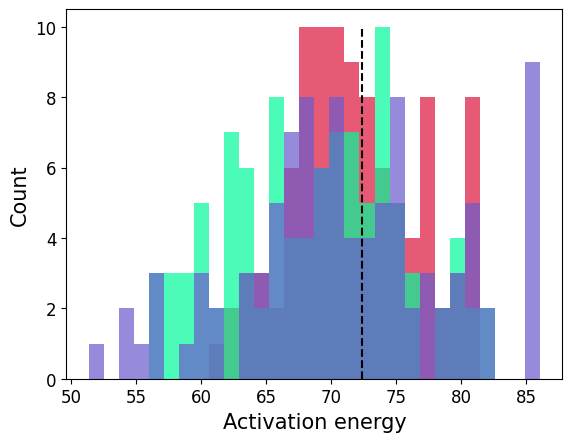

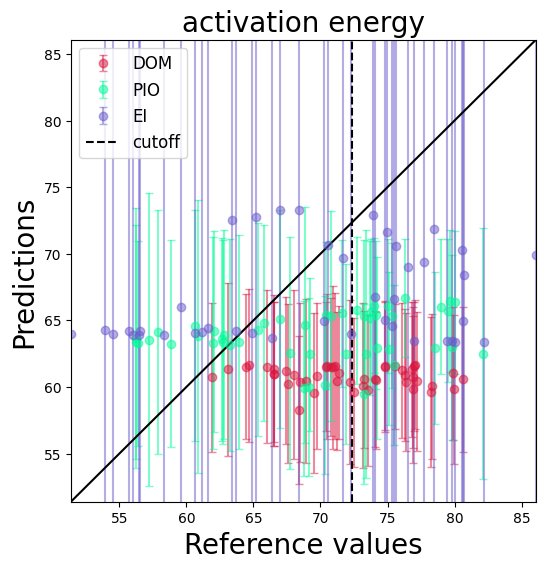

In [10]:
data_set = "reactivity"
target = "activation_energy"
data_path = "../Tartarus/datasets/reactivity.csv"
root_dir = "../RESULTS/{}".format(data_set+"_activation_energy")
objective_index = 0
objective = "minimize"
cutoff = 72.387 # 64.9362
save_path = "figures/6.svg"
prediction_index = 0
uncertainty_index = 2

cache_dict_path = "../RESULTS/{}/cal_dict.pkl".format(data_set)
predict_dict_path = "../RESULTS/{}/predict_dict.pkl".format(data_set)
with open(cache_dict_path, "rb") as f:
    cache_dict = pickle.load(f)
with open(predict_dict_path, "rb") as g:
    predict_dict = pickle.load(g)
    
sub_dir_name = ["janus_scaler", "original data", "janus_uncertainty", "janus_expected_improvement"]

color_dict = {"original data": "black", "janus_scaler":"crimson", "janus_uncertainty":"mediumspringgreen", "janus_expected_improvement":"#6A5ACD"}
num_fold = 20


data = pd.read_csv(data_path)
benchmark_dict = sample_data(sub_dir_name, target, cache_dict, num_fold, root_dir, -1, objective_index)
benchmark_dict.update({"original data": data})
# benchmark_dict["janus_scaler"]["activation_energy"].iloc[0] = float(78.264565)
overall_benchmark_dict.update({target: benchmark_dict})

method_list = ["janus_scaler", "janus_uncertainty", "janus_expected_improvement"]
compute_hit_rate(benchmark_dict, method_list, cutoff, target, objective, top_list=[10,50,100])
# create_1dplot(benchmark_dict, sub_dir_name, target, color_dict)
create_pd_plot(benchmark_dict, ["janus_scaler", "janus_uncertainty", "janus_expected_improvement"], color_dict, target, objective, cutoff, save_path=save_path)
# create_pd_plot(benchmark_dict, ["janus_expected_improvement"], color_dict, target, objective, cutoff, save_path="figures/ei_6.svg")
create_scatter_plot(benchmark_dict, predict_dict, target, prediction_index, uncertainty_index, cutoff)

## Reactivity (reaction energy)

janus_scaler, top-10 hit rate: 50.0%
janus_uncertainty, top-10 hit rate: 90.0%
janus_expected_improvement, top-10 hit rate: 70.0%
janus_scaler, top-50 hit rate: 36.0%
janus_uncertainty, top-50 hit rate: 82.0%
janus_expected_improvement, top-50 hit rate: 68.0%
janus_scaler, top-100 hit rate: 40.0%
janus_uncertainty, top-100 hit rate: 76.0%
janus_expected_improvement, top-100 hit rate: 56.99999999999999%


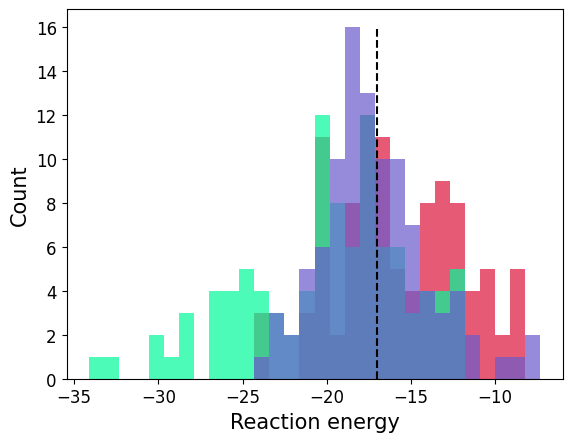

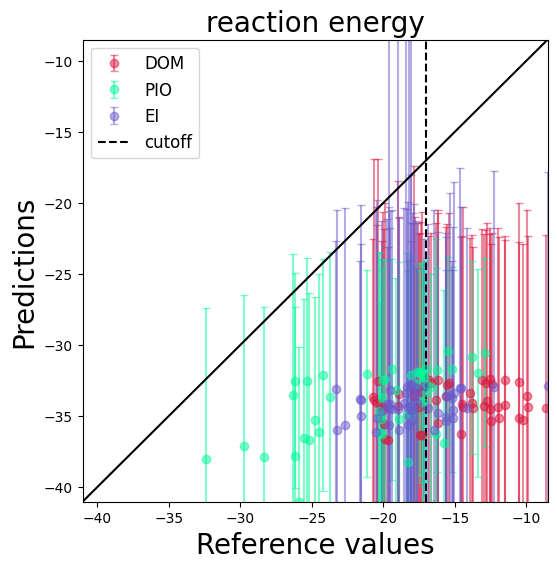

In [11]:
data_set = "reactivity"
target = "reaction_energy"
data_path = "../Tartarus/datasets/reactivity.csv"
root_dir = "../RESULTS/{}".format(data_set+"_reaction_energy")
objective_index = 1
objective = "minimize"
cutoff = -16.995 #-25.981 # 
save_path = "figures/7.svg"
prediction_index = 1
uncertainty_index = 3

cache_dict_path = "../RESULTS/{}/cal_dict.pkl".format(data_set)
predict_dict_path = "../RESULTS/{}/predict_dict.pkl".format(data_set)
with open(cache_dict_path, "rb") as f:
    cache_dict = pickle.load(f)
with open(predict_dict_path, "rb") as g:
    predict_dict = pickle.load(g)
    
sub_dir_name = ["janus_scaler", "original data", "janus_uncertainty", "janus_expected_improvement"]

# color_dict = {"original data": "black", "janus_scaler":"red", "janus_uncertainty":"green", "janus_expected_improvement":"cyan"}
color_dict = {"original data": "black", "janus_scaler":"crimson", "janus_uncertainty":"mediumspringgreen", "janus_expected_improvement":"#6A5ACD"}
num_fold = 15


data = pd.read_csv(data_path)
benchmark_dict = sample_data(sub_dir_name, target, cache_dict, num_fold, root_dir, -1, objective_index)
benchmark_dict.update({"original data": data})
overall_benchmark_dict.update({target: benchmark_dict})

method_list = ["janus_scaler", "janus_uncertainty", "janus_expected_improvement"]
compute_hit_rate(benchmark_dict, method_list, cutoff, target, objective, top_list=[10,50,100])
# create_1dplot(benchmark_dict, sub_dir_name, target, color_dict)
create_pd_plot(benchmark_dict, ["janus_scaler", "janus_uncertainty", "janus_expected_improvement"], color_dict, target, objective, cutoff, save_path=save_path)
# create_pd_plot(benchmark_dict, ["janus_expected_improvement"], color_dict, target, objective, cutoff, save_path="figures/ei_7.svg")
create_scatter_plot(benchmark_dict, predict_dict, target, prediction_index, uncertainty_index, cutoff)

## Plot 7 single-objective optimization results

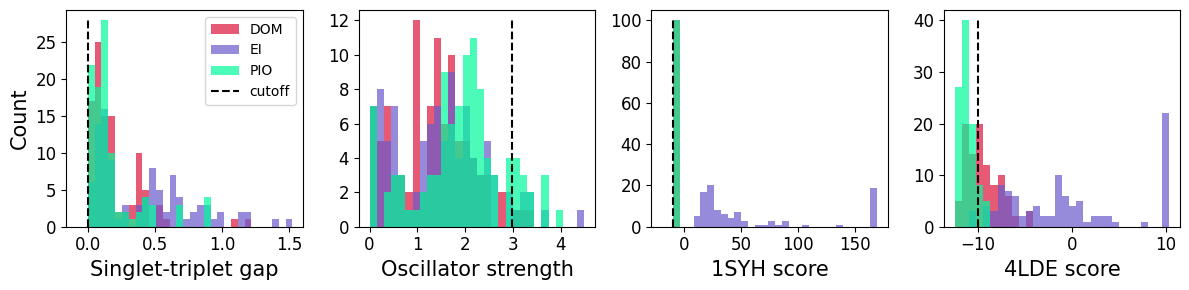

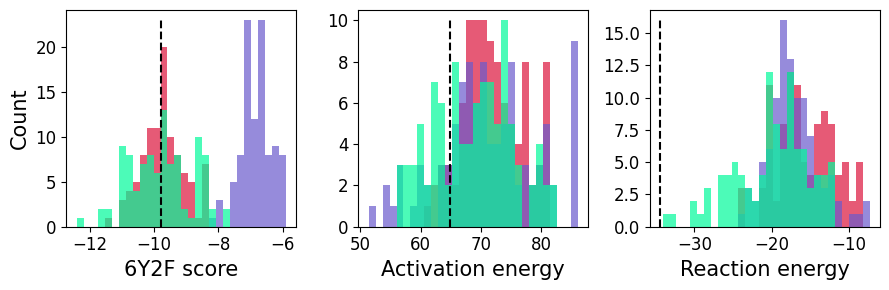

In [14]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path
import matplotlib.gridspec as gridspec

# color_dict = {"original data": "black", "janus_scaler":"#DC143C", "janus_uncertainty":"#228B22", "janus_expected_improvement":"cyan"}
color_dict = {"original data": "black", "janus_scaler":"crimson", "janus_uncertainty":"mediumspringgreen", "janus_expected_improvement":"#6A5ACD"} # 6A5ACD
all_targets = ['singlet-triplet_value', "oscillator_strength", '1syh_score', '4lde_score', '6y2f_score',
              'activation_energy', 'reaction_energy']
cutoff_dict = {'singlet-triplet_value': 0.002495, "oscillator_strength": 2.97372, 
               '1syh_score': -9.99, '4lde_score':-10.00, '6y2f_score':-9.80,
               'activation_energy': 64.9362, 'reaction_energy': -34.3875}
objective_dict = {'singlet-triplet_value': "minimize", "oscillator_strength": "maximize", 
               '1syh_score': "minimize", '4lde_score':"minimize", '6y2f_score':"minimize",
               'activation_energy': "minimize", 'reaction_energy': "minimize"}



fig = plt.figure(figsize=(12,3))
# 將每個SVG文件加載為Matplotlib OffsetImage對象，然後將它們添加到子圖中
for i in range(4):
    number = int("14"+str(i+1))
    plt.subplot(number)
    target = all_targets[i]
    cutoff = cutoff_dict[target]
    objective = objective_dict[target]
    benchmark_dict = overall_benchmark_dict[target]
    if target in ['singlet-triplet_value', '1syh_score']:
        expand_xlim=True
    else:
        expand_xlim=False
    if i == 0:
        create_pd_plot(benchmark_dict, ["janus_scaler", "janus_expected_improvement", "janus_uncertainty"], color_dict, target,objective, cutoff,oneplot=False, expand_xlim=expand_xlim)
        plt.legend(labels=['DOM', 'EI','PIO', "cutoff"], fontsize=10)
    else:
        create_pd_plot(benchmark_dict, ["janus_scaler", "janus_expected_improvement", "janus_uncertainty"], color_dict, target,objective, cutoff,oneplot=False,ylabel=False, expand_xlim=expand_xlim)
plt.tight_layout()
plt.savefig("figures/ei_overall_1.svg")
plt.show()


fig = plt.figure(figsize=(9,3))
# 將每個SVG文件加載為Matplotlib OffsetImage對象，然後將它們添加到子圖中
for i in range(4,7):
    number = int("13"+str(i-4+1))
    plt.subplot(number)
    target = all_targets[i]
    cutoff = cutoff_dict[target]
    objective = objective_dict[target]
    benchmark_dict = overall_benchmark_dict[target]
    if i==4:
        create_pd_plot(benchmark_dict, ["janus_scaler", "janus_expected_improvement", "janus_uncertainty"], color_dict, target, objective, cutoff,oneplot=False,)
    else:
        create_pd_plot(benchmark_dict, ["janus_scaler", "janus_expected_improvement", "janus_uncertainty"], color_dict, target, objective, cutoff,oneplot=False,ylabel=False, )

plt.tight_layout()
plt.savefig("figures/ei_overall_2.svg")
plt.show()

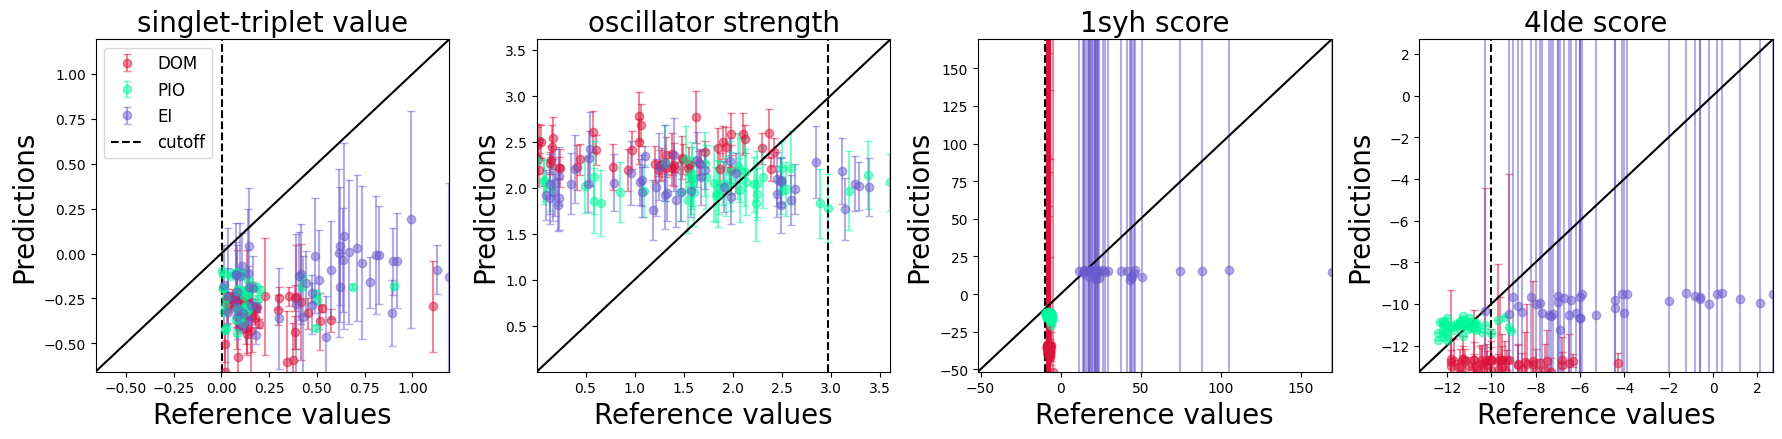

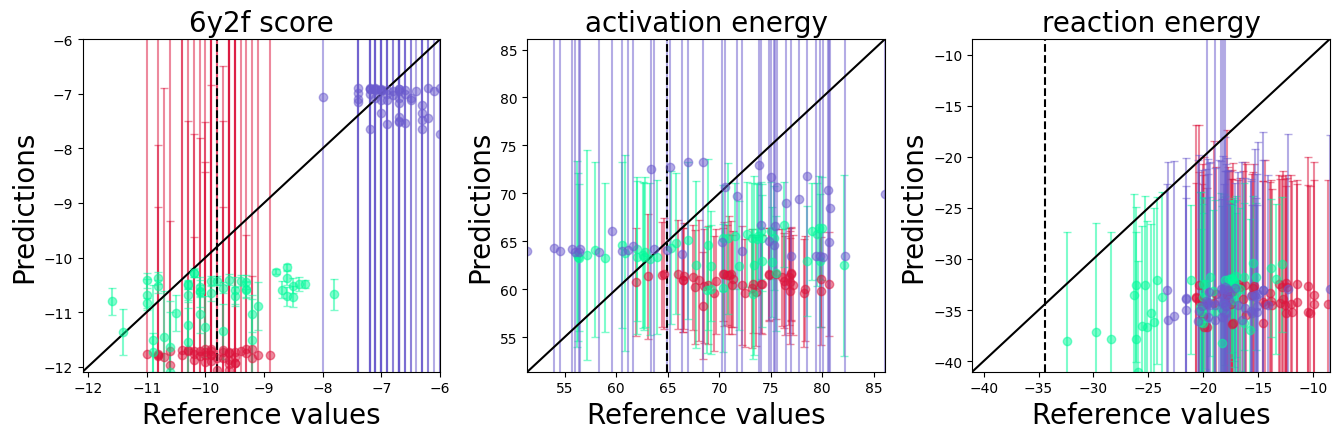

In [15]:
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path
import matplotlib.gridspec as gridspec

# color_dict = {"original data": "black", "janus_scaler":"#DC143C", "janus_uncertainty":"#228B22", "janus_expected_improvement":"cyan"}
color_dict = {"original data": "black", "janus_scaler":"crimson", "janus_uncertainty":"mediumspringgreen", "janus_expected_improvement":"#6A5ACD"} # 6A5ACD
all_targets = ['singlet-triplet_value', "oscillator_strength", '1syh_score', '4lde_score', '6y2f_score',
              'activation_energy', 'reaction_energy']
cutoff_dict = {'singlet-triplet_value': 0.002495, "oscillator_strength": 2.97372, 
               '1syh_score': -9.99, '4lde_score':-10.00, '6y2f_score':-9.80,
               'activation_energy': 64.9362, 'reaction_energy': -34.3875}
objective_dict = {'singlet-triplet_value': "minimize", "oscillator_strength": "maximize", 
               '1syh_score': "minimize", '4lde_score':"minimize", '6y2f_score':"minimize",
               'activation_energy': "minimize", 'reaction_energy': "minimize"}
data_set_names = ["organic_emitter"]*2 + ["docking"]*3 + ["reactivity"]*2
prediction_index_list =  [0,1,0,1,2,0,1]
uncertainty_index_list = [3,4,3,4,5,2,3]

fig = plt.figure(figsize=(18,4.5))
# 將每個SVG文件加載為Matplotlib OffsetImage對象，然後將它們添加到子圖中
for i in range(4):
    data_set = data_set_names[i]
    predict_dict_path = "../RESULTS/{}/predict_dict.pkl".format(data_set)
    with open(predict_dict_path, "rb") as g:
        predict_dict = pickle.load(g)
    number = int("14"+str(i+1))
    plt.subplot(number)
    target = all_targets[i]
    cutoff = cutoff_dict[target]
    objective = objective_dict[target]
    benchmark_dict = overall_benchmark_dict[target]

    if i == 0:
        create_scatter_plot(benchmark_dict, predict_dict, target, prediction_index_list[i], uncertainty_index_list[i], cutoff,show=False)
    else:
        create_scatter_plot(benchmark_dict, predict_dict, target, prediction_index_list[i], uncertainty_index_list[i], cutoff, legend=False,show=False)
plt.tight_layout()
plt.savefig("figures/parity_1.svg")
plt.show()


fig = plt.figure(figsize=(13.5, 4.5))
# 將每個SVG文件加載為Matplotlib OffsetImage對象，然後將它們添加到子圖中
for i in range(4,7):
    data_set = data_set_names[i]
    predict_dict_path = "../RESULTS/{}/predict_dict.pkl".format(data_set)
    with open(predict_dict_path, "rb") as g:
        predict_dict = pickle.load(g)
    number = int("13"+str(i-4+1))
    plt.subplot(number)
    target = all_targets[i]
    cutoff = cutoff_dict[target]
    objective = objective_dict[target]
    benchmark_dict = overall_benchmark_dict[target]
    create_scatter_plot(benchmark_dict, predict_dict, target, prediction_index_list[i], uncertainty_index_list[i], cutoff, legend=False,show=False)
plt.tight_layout()
plt.savefig("figures/parity_2.svg")
plt.show()